Our goal is to fill in the empty spots of the co-occurence matrix. Prior ideas were to generate vectors for users and items and use cosine similarity to find similar items(Item CF and User CF).

Now matrix factorization is widely used. Item CF and User CF suffer from recomending only popular items. Vectors tend to cluster toward the popular items, so recomendations become less meaningful.

We can use linear algebra to calculate the co-occurence matrix. We can generate embeddings for users and embeddings for items and place them in respective matrices such that when we multiply these embedding matrices we get the scores in the co-occurence matrix.

We can thing of embeddings as a vector of latent factors that store user preferences. For this we are using direct lookup embeddings.

# **Matrix Factorization with Deep Learning (Neural Collaborative Learning)**

**Imports**

In [222]:
import pandas as pd
import numpy as np
from sklearn import model_selection, metrics, preprocessing
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from fastai.collab import *
from fastai.tabular.all import *
path = untar_data(URLs.ML_100k)

**Get Dataset**

In [223]:
df = pd.read_csv('/content/ml-latest-small/ratings.csv')

In [224]:
df.info() # we are not worried about timestamp

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [225]:
df.userId.nunique()

610

In [226]:
print(df['userId'].min())
print(df['userId'].max())

1
610


In [227]:
df.movieId.nunique()

9724

In [228]:
print(df['movieId'].min())
print(df['movieId'].max())

1
193609


In [229]:
df.rating.value_counts()

,count
rating,
4.0,26818
3.0,20047
5.0,13211
3.5,13136
4.5,8551
2.0,7551
2.5,5550
1.0,2811
1.5,1791


In [230]:
df.shape

(100836, 4)

**Dataset Class Wrapper**

In [231]:
class MovieDataset:
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings

    def __len__(self):
        return len(self.users)

    def __getitem__(self, item):
        users = self.users[item]
        movies = self.movies[item]
        ratings = self.ratings[item]

        return {
            "users": torch.tensor(users, dtype=torch.long),
            "movies": torch.tensor(movies, dtype=torch.long),
            "ratings": torch.tensor(ratings, dtype=torch.long)
        }



**Create the Model**

In [232]:
class CollabNN(nn.Module):
    def __init__(self, user_size, movies_size):
        super().__init__()
        # train the embedding matrix

        self.user_embeddings = nn.Embedding(user_size, 50)
        self.movie_embeddings = nn.Embedding(movies_size, 50)
        # concatenate embeddings into a vector of length 64
        self.out = nn.Linear(100, 1)


    def forward(self, users, movies, ratings=None):
        user_embeddings = self.user_embeddings(users)
        movie_embeddings = self.movie_embeddings(movies)
        output = torch.cat([user_embeddings, movie_embeddings], dim = 1)

        output = self.out(output)

        return output



Preprocess the data a bit

In [233]:
user_label = preprocessing.LabelEncoder()
movie_label = preprocessing.LabelEncoder()
df['userId'] = user_label.fit_transform(df['userId'].values)
df['movieId'] = movie_label.fit_transform(df['movieId'].values)

**Prepare the training and validation sets**

In [234]:
df_train, df_valid = model_selection.train_test_split(df, test_size=0.2, random_state=42, stratify=df.rating.values)

train_dataset = MovieDataset(
    users = df_train.userId.values,
    movies = df_train.movieId.values,
    ratings = df_train.rating.values
)

valid_dataset = MovieDataset(
    users = df_valid.userId.values,
    movies = df_valid.movieId.values,
    ratings = df_valid.rating.values
)

In [235]:
train_loader = DataLoader(dataset=train_dataset, batch_size=4, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=4, shuffle=True, num_workers=4)

dataiter = iter(train_loader)
dataloader_data = dataiter.__next__()
print(dataloader_data)

{'users': tensor([355, 122, 246, 553]), 'movies': tensor([2329, 7355, 7285, 1935]), 'ratings': tensor([4, 4, 3, 4])}


**Initialize the Model**

In [236]:
model = CollabNN(
    user_size = len(user_label.classes_), # unqiue users
    movies_size = len(movie_label.classes_), # unique movies
    )

optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.7) # adjust the learning rate

loss_func = nn.MSELoss()

**Sanity Check Dimensions**

In [237]:
print(dataloader_data['users'])
print(dataloader_data['users'].size())

print(dataloader_data['movies'])
print(dataloader_data['movies'].size())

user_embeddings = nn.Embedding(len(user_label.classes_), 50)
movie_embeddings = nn.Embedding(len(movie_label.classes_), 50)
out = nn.Linear(100, 1)

tensor([355, 122, 246, 553])
torch.Size([4])
tensor([2329, 7355, 7285, 1935])
torch.Size([4])


In [238]:
user_embeddings = user_embeddings(dataloader_data['users'])
movie_embeddings = movie_embeddings(dataloader_data['movies'])
print(f"user embeddings {user_embeddings.size()}")
print(f"user embeddings {user_embeddings}")
print(f"movie embeddings {movie_embeddings.size()}")
print(f"user embeddings {movie_embeddings}")
# each batch has 4 users with embeddings of size 50 and the same for movies

user embeddings torch.Size([4, 50])
user embeddings tensor([[ 8.3836e-01, -1.8569e+00,  7.3473e-02, -1.2689e-01,  1.1451e+00,
         -4.6266e-03, -3.4265e-01,  1.2676e-01, -7.8257e-01, -1.8183e+00,
          1.6592e+00, -9.2293e-01, -2.1381e-02, -5.5025e-01, -1.5062e-01,
          5.6189e-01, -1.0540e+00,  3.2588e-02,  6.8780e-01, -1.0874e+00,
         -1.3878e-01,  3.2726e-02, -2.9769e-01, -5.5891e-01,  1.0432e-01,
         -1.5593e-01, -1.1074e-01, -5.1352e-02,  9.7357e-01,  3.3087e+00,
         -1.1080e+00, -1.7208e+00,  6.7881e-01,  2.6067e-01,  2.3545e+00,
         -4.7901e-01, -4.7139e-01, -2.5136e+00,  1.1295e-01,  8.5171e-01,
          3.2455e-01,  6.4691e-01, -2.6984e-01, -4.2990e-01,  1.9703e+00,
         -9.3220e-01, -1.9279e-01, -5.8961e-01,  2.0923e+00,  5.4612e-01],
        [-8.7291e-01, -8.7524e-02,  8.3550e-01,  9.5529e-01, -2.1535e+00,
         -3.8283e-01, -1.0297e+00,  2.4651e+00, -4.8144e-01,  5.3339e-01,
          5.0100e-01, -5.3837e-01,  2.8948e+00,  5.4978e-01

In [239]:
output = torch.cat([user_embeddings, movie_embeddings], dim=1) # 4 of size 100 (50 + 50)
print(f"output: {output.size()}")
print(f"output: {output}")
output = out(output) # each vector gives one output
print(f"output: {output}")


output: torch.Size([4, 100])
output: tensor([[ 8.3836e-01, -1.8569e+00,  7.3473e-02, -1.2689e-01,  1.1451e+00,
         -4.6266e-03, -3.4265e-01,  1.2676e-01, -7.8257e-01, -1.8183e+00,
          1.6592e+00, -9.2293e-01, -2.1381e-02, -5.5025e-01, -1.5062e-01,
          5.6189e-01, -1.0540e+00,  3.2588e-02,  6.8780e-01, -1.0874e+00,
         -1.3878e-01,  3.2726e-02, -2.9769e-01, -5.5891e-01,  1.0432e-01,
         -1.5593e-01, -1.1074e-01, -5.1352e-02,  9.7357e-01,  3.3087e+00,
         -1.1080e+00, -1.7208e+00,  6.7881e-01,  2.6067e-01,  2.3545e+00,
         -4.7901e-01, -4.7139e-01, -2.5136e+00,  1.1295e-01,  8.5171e-01,
          3.2455e-01,  6.4691e-01, -2.6984e-01, -4.2990e-01,  1.9703e+00,
         -9.3220e-01, -1.9279e-01, -5.8961e-01,  2.0923e+00,  5.4612e-01,
         -9.1365e-01,  1.1992e+00, -4.0870e-02,  1.7800e+00, -8.6763e-01,
          2.0812e+00, -4.3048e-01, -7.5743e-02, -8.7421e-01,  7.9325e-01,
         -1.1424e+00, -2.7731e-02, -4.6516e-01,  3.7930e-01,  1.4209e-01,
 

**Run one pass on the first batch to see outputs**

In [240]:
with torch.no_grad():
    model_output = model(dataloader_data['users'], dataloader_data['movies'])

    print(f"model_output {model_output}, size: {model_output.size()}")

model_output tensor([[ 0.0440],
        [-0.2277],
        [ 0.4262],
        [ 0.1148]]), size: torch.Size([4, 1])


In [242]:
rating = dataloader_data['ratings']
print(rating)
print(rating.view(4,-1))
print(model_output)
print(rating.sum())
print(model_output.sum() - rating.sum()) # we would expect this to be way off with no training

tensor([4, 4, 3, 4])
tensor([[4],
        [4],
        [3],
        [4]])
tensor([[ 0.0440],
        [-0.2277],
        [ 0.4262],
        [ 0.1148]])
tensor(15)
tensor(-14.6427)


**Run the training loop**

In [244]:
# seems to perform well with just one epoch
epochs = 1
total_loss = 0
plot_steps, print_steps = 5000, 5000
step_count = 0
losses = []

model.train()
for epoch_i in range(epochs):
    for i, train_data in enumerate(train_loader):
        output = model(train_data['users'], train_data['movies'])

        rating = train_data['ratings'].view(4,-1).to(torch.float32) # reshape rating to match model output

        loss = loss_func(output, rating)
        total_loss += loss.sum().item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        step_count += len(train_data['users'])

        if step_count % plot_steps == 0:
            avg_loss = total_loss / (len(train_data['users']) * plot_steps)
            print(f"epoch {epoch_i} loss at step: {step_count} is {avg_loss}")
            losses.append(avg_loss)
            total_loss = 0

epoch 0 loss at step: 5000 is 0.4442247957956046
epoch 0 loss at step: 10000 is 0.15959819666985423
epoch 0 loss at step: 15000 is 0.10109061435470358
epoch 0 loss at step: 20000 is 0.07890421410221607
epoch 0 loss at step: 25000 is 0.06788954608291388
epoch 0 loss at step: 30000 is 0.06493925310457126
epoch 0 loss at step: 35000 is 0.06389428157648072
epoch 0 loss at step: 40000 is 0.06425137394149788
epoch 0 loss at step: 45000 is 0.06109026636504568
epoch 0 loss at step: 50000 is 0.06259844285866711
epoch 0 loss at step: 55000 is 0.05871980836875737
epoch 0 loss at step: 60000 is 0.05968300875648856
epoch 0 loss at step: 65000 is 0.05872892393022776
epoch 0 loss at step: 70000 is 0.05438373775202781
epoch 0 loss at step: 75000 is 0.05690488904989324
epoch 0 loss at step: 80000 is 0.055658210853114724


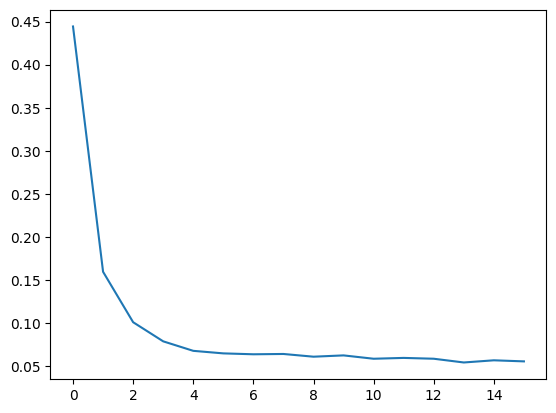

In [245]:
plt.figure()
plt.plot(losses)
plt.show()

**Evaluate with RMSE**

In [246]:
from sklearn.metrics import mean_squared_error

model_output_list = []
target_rating_list = []

model.eval()

with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        model_output = model(batched_data['users'], batched_data['movies'])

        model_output_list.append(model_output.sum().item() / len(batched_data['users']))
        target_rating = batched_data['ratings']
        target_rating_list.append(target_rating.sum().item() / len(batched_data['users']))
        print(f"model_output: {model_output}, target_rating: {target_rating}")

rms = mean_squared_error(target_rating_list, model_output_list, squared=False)
print(f"rms: {rms}")


Streaming output truncated to the last 5000 lines.
        [3.0370],
        [3.6315],
        [2.5624]]), target_rating: tensor([2, 3, 5, 1])
model_output: tensor([[3.9207],
        [3.3237],
        [2.3415],
        [3.4579]]), target_rating: tensor([4, 3, 2, 2])
model_output: tensor([[2.2611],
        [3.1379],
        [3.9969],
        [3.5001]]), target_rating: tensor([2, 3, 4, 0])
model_output: tensor([[4.1894],
        [3.4637],
        [2.5248],
        [3.6159]]), target_rating: tensor([3, 4, 3, 4])
model_output: tensor([[3.0849],
        [2.7314],
        [3.3932],
        [3.7481]]), target_rating: tensor([4, 3, 2, 4])
model_output: tensor([[4.2270],
        [2.9816],
        [2.7342],
        [3.4322]]), target_rating: tensor([4, 3, 4, 4])
model_output: tensor([[3.2903],
        [3.6870],
        [3.9035],
        [3.6773]]), target_rating: tensor([2, 4, 5, 2])
model_output: tensor([[3.2027],
        [2.6963],
        [3.5813],
        [3.7343]]), target_rating: tensor([3,

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


rms: 0.48120752675508477 not bad considering rating are on the scale 0-5.

**Lets Consider Recall and Precision at k**

Recall is # of recommended items @k that are relevant / total # of relevant items

Precision is # of recommended items @k that are relevant / # of recommended items at k

k is some threshold for the number of items we want to consider

In [247]:
from collections import defaultdict

user_est_true = defaultdict(list)

# iterate through the validation data to build the user -> [(y1, y1_hat), (y2, y2_hat), ...]
# generating actual vs predicted list for users, we can sort by y_hat to get predictions
with torch.no_grad():
    for i, batched_data in enumerate(validation_loader):
        users = batched_data['users']
        movies = batched_data['movies']
        ratings = batched_data['ratings']

        model_output = model(users, movies)

        for i in range(len(users)):
            user_id = users[i].item()
            movie_id = movies[i].item()
            pred_rating = model_output[i][0].item()
            true_rating = ratings[i].item()

            print(f"user_id: {user_id}, movie_id: {movie_id}, pred_rating: {pred_rating}, true_rating: {true_rating}")
            user_est_true[user_id].append((pred_rating, true_rating))

Streaming output truncated to the last 5000 lines.
user_id: 218, movie_id: 6596, pred_rating: 3.27888822555542, true_rating: 4
user_id: 306, movie_id: 2552, pred_rating: 2.722238540649414, true_rating: 4
user_id: 390, movie_id: 2312, pred_rating: 3.5908455848693848, true_rating: 5
user_id: 473, movie_id: 2315, pred_rating: 2.9800825119018555, true_rating: 2
user_id: 247, movie_id: 9133, pred_rating: 3.4133100509643555, true_rating: 4
user_id: 209, movie_id: 9704, pred_rating: 3.233417272567749, true_rating: 1
user_id: 124, movie_id: 6867, pred_rating: 3.8736112117767334, true_rating: 3
user_id: 312, movie_id: 2898, pred_rating: 3.252924919128418, true_rating: 2
user_id: 209, movie_id: 6938, pred_rating: 2.8962206840515137, true_rating: 2
user_id: 287, movie_id: 126, pred_rating: 2.8178181648254395, true_rating: 2
user_id: 367, movie_id: 1015, pred_rating: 2.7192397117614746, true_rating: 2
user_id: 304, movie_id: 2380, pred_rating: 4.2063493728637695, true_rating: 3
user_id: 303, movie

In [248]:
with torch.no_grad():
  precisoins = {}
  recalls = {}

  k = 100
  thershold = 3.5

  for user_id, user_ratings in user_est_true.items():

      # sort user ratings by estimated rating
      user_ratings.sort(key=lambda x: x[0], reverse=True)

      # get the num of actual relevant items
      num_rel = sum((true_rating >= thershold) for (_,true_rating) in user_ratings)

      # number of recommended items that are predicted relevant and within topk
      num_rec_k = sum((est >= thershold) for (est, _) in user_ratings[:k])

      # number of relevant items that are predicted relevant and within topk
      num_rel_and_rec_k = sum(((true_rating >= thershold) and (est >= thershold))
                              for (est, true_rating) in user_ratings[:k])

      print(f"user_id: {user_id}, num_rel: {num_rel}, num_rec_k: {num_rec_k}, num_rel_and_rec_k: {num_rel_and_rec_k}")

      # Precision: proportion of recommended items that are relevant
      precision = num_rel_and_rec_k / num_rec_k if num_rec_k != 0 else 0

      # Recall: proportion of relevant items that are recommended
      recall = num_rel_and_rec_k / num_rel if num_rel != 0 else 0

      precisoins[user_id] = precision
      recalls[user_id] = recall



user_id: 233, num_rel: 24, num_rec_k: 2, num_rel_and_rec_k: 1
user_id: 476, num_rel: 72, num_rec_k: 30, num_rel_and_rec_k: 25
user_id: 228, num_rel: 9, num_rec_k: 10, num_rel_and_rec_k: 8
user_id: 327, num_rel: 24, num_rec_k: 3, num_rel_and_rec_k: 3
user_id: 386, num_rel: 61, num_rec_k: 18, num_rel_and_rec_k: 14
user_id: 177, num_rel: 8, num_rec_k: 9, num_rel_and_rec_k: 5
user_id: 44, num_rel: 46, num_rec_k: 61, num_rel_and_rec_k: 41
user_id: 468, num_rel: 53, num_rec_k: 57, num_rel_and_rec_k: 39
user_id: 291, num_rel: 34, num_rec_k: 25, num_rel_and_rec_k: 17
user_id: 161, num_rel: 6, num_rec_k: 9, num_rel_and_rec_k: 6
user_id: 326, num_rel: 8, num_rec_k: 10, num_rel_and_rec_k: 6
user_id: 338, num_rel: 52, num_rec_k: 44, num_rel_and_rec_k: 31
user_id: 478, num_rel: 20, num_rec_k: 11, num_rel_and_rec_k: 8
user_id: 365, num_rel: 2, num_rec_k: 2, num_rel_and_rec_k: 2
user_id: 319, num_rel: 1, num_rec_k: 0, num_rel_and_rec_k: 0
user_id: 488, num_rel: 39, num_rec_k: 0, num_rel_and_rec_k: 0


In [249]:
# Average precision and recall over all users
print(f"precision @ {k}: {sum(precisoins.values()) / len(precisoins)}")
print(f"recall @ {k}: {sum(recalls.values()) / len(recalls)}")

precision @ 100: 0.5832135033747952
recall @ 100: 0.5291393801667774
